# Introduction

For this final project, I am making a trajectory prediction for the ball in a simulated physics envornment. For the simulation, I am using the Phyre benchmark simulator. For machine learning, I am training the Echo State Networks.

This submission consists of three parts:

1. **Simulator Demo.** In this section, I will make a short demo of how the Phyre simulator works and what kind of output we can get from it.

2. **Data preparation.** In this section, I am creating the dataset of simulations using Phyre. This consists of two parts:

    - Generating a dataset using Phyre.
    
    - Creating a set of PyTorch Dataset classes that will be used to feed the data into a machine learning model. **NOTE:** these classes are defined and implemented in a separate file named `PhyreDataset.py`. I will include the code in the end of the PDF submission; this file will also come in a zip archive in a secondary submission.

3. **ESN Training**. In this section I am training three Echo State Networks.

    - One takes the entire scene, frame by frame, as an input, and predicts the entire scene as an output.
    
    - One takes the entire scene as an input, where the flattened data from three consecutive frames is combined as a single input row, and predicts the trajectory of one of the balls as an output.
    
    - One takes the flattened data from three consecutive frames as an input (just three frames), and provides a single pair of coordinates for one ball on the following frame as an output.
    
I have to note here that a big part of this project was trying to replicate existing tutorials but on the Phyre dataset. I will attach notes to which parts of the code was borrowed and in which way it was modified to satisfy my project goals.

# Simulator Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import random
import math

import phyre

Let's start with a short simulator demo. The code below is taken from Phyre example notebook. You can find the tutorial using the link below:

https://github.com/facebookresearch/phyre/blob/main/examples/01_phyre_intro.ipynb

In [2]:
# Choosing a setup where only one ball is needed
eval_setup = 'ball_cross_template'

# Getting just one fold of scenarios from the simulator
fold_id = 0

# Getting the tasks split into training, validation, and test
train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
print('Size of resulting splits:\n train:', len(train_tasks), '\n dev:',
      len(dev_tasks), '\n test:', len(test_tasks))

Size of resulting splits:
 train: 1600 
 dev: 400 
 test: 500


In [3]:
# Getting action tier for our tasks - a single ball
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

Action tier for ball_cross_template is ball


In [4]:
# Let's set our tasks to first 50 of the dev set 
tasks = dev_tasks[:50]

# Create the simulator from the tasks and tier.
simulator = phyre.initialize_simulator(tasks, action_tier)

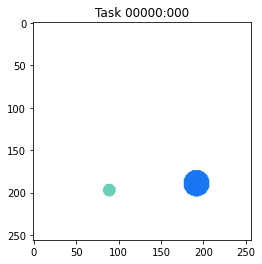

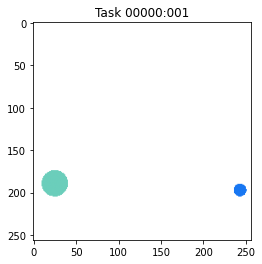

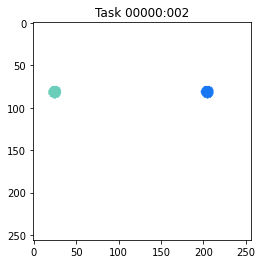

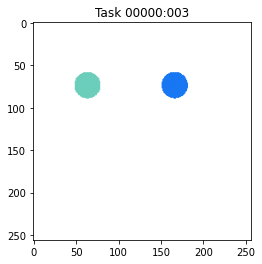

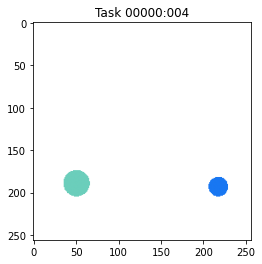

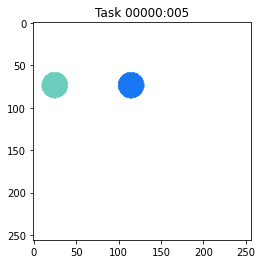

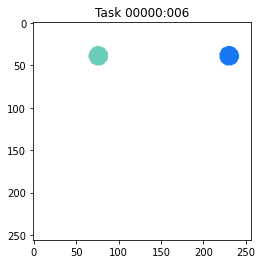

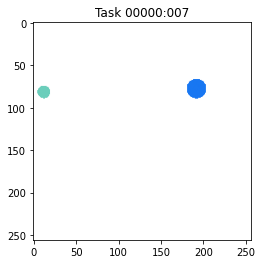

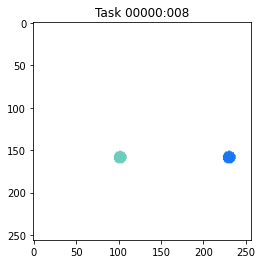

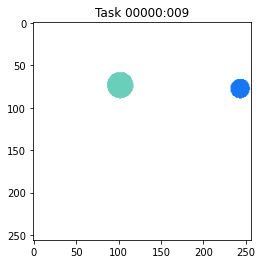

In [5]:
# Showing initial stages of the first 10 scenes
for task_index in range(min(10, len(tasks))):
    initial_scene = simulator.initial_scenes[task_index]
    plt.imshow(phyre.observations_to_float_rgb(initial_scene))
    plt.title(f'Task {simulator.task_ids[task_index]}');
    plt.show()

In [6]:
# getting a 100 actions from a simulator
# it uniformly samples actions skipping invalid ones
# Action dimensions: 3 (x, y, radius)

actions = simulator.build_discrete_action_space(max_actions=100)

# Let's simulate for the random actions
action = random.choice(actions)

In [7]:
# Simulating for the first sampled action
task_index = 0
simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True)

In [8]:
# Checking the simulator response
print('Result of taking action', action, 'on task', tasks[task_index], 'is:',
      simulation.status)
print('Does', action, 'solve task', tasks[task_index], '?', simulation.status.is_solved())
print('Is', action, 'an invalid action on task', tasks[task_index], '?',
      simulation.status.is_invalid())

Result of taking action [0.86354185 0.74712164 0.55624023] on task 00000:000 is: SimulationStatus.SOLVED
Does [0.86354185 0.74712164 0.55624023] solve task 00000:000 ? True
Is [0.86354185 0.74712164 0.55624023] an invalid action on task 00000:000 ? False


Number of observations returned by simulator: 17


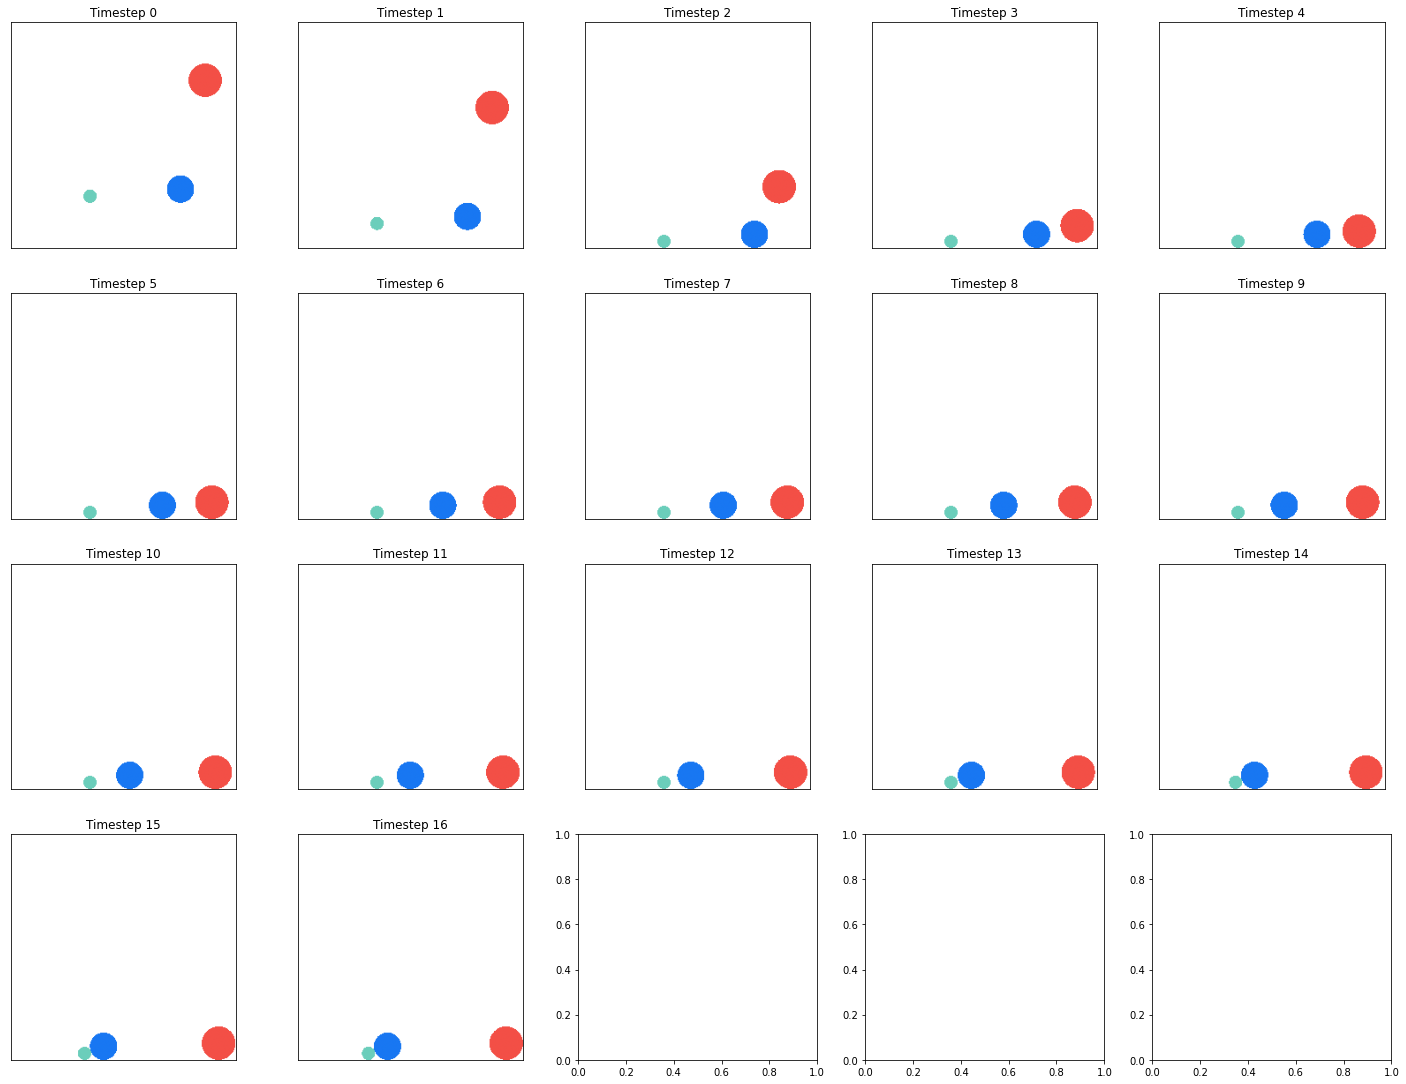

In [9]:
# Displaying the simulation
print('Number of observations returned by simulator:', len(simulation.images))

num_across = 5
height = int(math.ceil(len(simulation.images) / num_across))
fig, axs = plt.subplots(height, num_across, figsize=(20, 15))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# We can visualize the simulation at each timestep.
for i, (ax, image) in enumerate(zip(axs.flatten(), simulation.images)):
    # Convert the simulation observation to images.
    img = phyre.observations_to_float_rgb(image)
    ax.imshow(img)
    ax.title.set_text(f'Timestep {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

For my data preparation, I am interested in saving three features for each ball: x and y coordinates and the balls' diameters. Let's take a look on the form of output that we can get for this purpose.

In [10]:
# We can get the response from the simulator in a matrix form
featurized_objects = simulation.featurized_objects

# I am interested in saving coordinates and diameters for every object
# This is because I am limiting my model to work only with balls, so these features are enough
# The last component of the output corresponds to the red ball - the one we are interested in

# X-coordinates by frame
print('X-coordinates by frame')
print(featurized_objects.xs)
print()

# Y-coordinates by frame
print('Y-coordinates by frame')
print(featurized_objects.ys)
print()

# Diameters
print('Diameters')
print(featurized_objects.diameters)

X-coordinates by frame
[[0.35       0.75       0.859375  ]
 [0.35       0.75       0.859375  ]
 [0.35       0.75       0.859375  ]
 [0.35       0.7283796  0.9079187 ]
 [0.35       0.6991054  0.8859483 ]
 [0.35       0.6699288  0.8889642 ]
 [0.35       0.64084935 0.89197004]
 [0.35       0.6118668  0.8949659 ]
 [0.35       0.58298075 0.89795136]
 [0.35       0.554191   0.900927  ]
 [0.35       0.52549726 0.9038928 ]
 [0.35       0.49689907 0.9068488 ]
 [0.35       0.4683962  0.90979505]
 [0.35       0.43998826 0.9127316 ]
 [0.33897987 0.42306018 0.91565806]
 [0.32555503 0.4096508  0.9185748 ]
 [0.31217507 0.39628595 0.92148185]]

Y-coordinates by frame
[[0.22923309 0.26048306 0.7421237 ]
 [0.10864712 0.1398971  0.62153774]
 [0.02942147 0.06066259 0.27126455]
 [0.02942147 0.06066405 0.0988986 ]
 [0.02942147 0.06066405 0.07438174]
 [0.02942147 0.06066405 0.07438174]
 [0.02942147 0.06066405 0.07438174]
 [0.02942147 0.06066405 0.07438174]
 [0.02942147 0.06066405 0.07438174]
 [0.02942147 0.0

All the numbers here are normalized by the width and height of the scene, so are bound between 0 and 1.

From the output above we can see that the first component corresponds to the green ball, the second - to the blue ball, and the third - to the red ball.

# Data preparation

So my data preparation consists of the following steps:

1. Simulate a bunch of scenarios

2. For each scenario and for each frame save the position and diameter of each ball.
    
So the data that I save has the following dimensions: (n_frames, n_objects, 3), where 3 corresponds to (x, y, diameter). I will save the output in a separate file for each sinle simulation - thus, I will have `n_tasks` * `n_valid_actions` files.

Also, in the process of making this assignment, I noticed that more than 90% of all simulations consists of 17 frames. Thus, I decided to throw out all of the other ones to make all my data consistent.

In [11]:
for task_index in range(len(tasks)):
    for action_index in range(len(actions)):
        simulation = simulator.simulate_action(task_index, actions[action_index], need_images=True, need_featurized_objects=True)

        # if action was invalid, don't solve and continue to next
        if simulation.status.is_invalid(): continue

        featurized_objects = simulation.featurized_objects

        data = []
        for frame_number in range(len(featurized_objects.features)):
            features = []
            features.append(featurized_objects.xs[frame_number])
            features.append(featurized_objects.ys[frame_number])
            features.append(featurized_objects.diameters)
            features = np.array(features).T
            data.append(features)
        
        # Also skip if not 17 frames in a simulation
        if len(data) != 17: continue
            
        np.save(f'data/task-{task_index}-action-{action_index}', data)

We just ended up saving 4,178 simulations. Let's try to load one of the files to assure that the data saves correctly.

In [12]:
np.load('data/task-0-action-0.npy')

array([[[0.35      , 0.22923309, 0.05859375],
        [0.75      , 0.26048306, 0.12109375],
        [0.4140625 , 0.71478   , 0.015625  ]],

       [[0.35      , 0.10864712, 0.05859375],
        [0.75      , 0.1398971 , 0.12109375],
        [0.4140625 , 0.594194  , 0.015625  ]],

       [[0.35      , 0.02942147, 0.05859375],
        [0.75      , 0.06066259, 0.12109375],
        [0.4140625 , 0.24392076, 0.015625  ]],

       [[0.35      , 0.02942147, 0.05859375],
        [0.75      , 0.06066405, 0.12109375],
        [0.4140625 , 0.03623718, 0.015625  ]],

       [[0.35      , 0.02942147, 0.05859375],
        [0.75      , 0.06066405, 0.12109375],
        [0.4140625 , 0.00793899, 0.015625  ]],

       [[0.35      , 0.02942147, 0.05859375],
        [0.75      , 0.06066405, 0.12109375],
        [0.4140625 , 0.00793899, 0.015625  ]],

       [[0.35      , 0.02942147, 0.05859375],
        [0.75      , 0.06066405, 0.12109375],
        [0.4140625 , 0.00793899, 0.015625  ]],

       [[0.35      ,

Yay, great success. We can now go ahead and setup the models.

# ESN Training

Let's first try to summasize briefly what is an Echo State Network and why it might be good for this kind of tasks.

So ESN is a three layer network, where the first layer in an input, the last layer is an output, and the hidden layer is a big reservoir of randomly interconnected neurons (including some that are recurrent). The first two layers are not trainable; the only thing that is trainable is the matrix that matches the output of reservoir to the output layer. Here is a beautiful picture that shows the structure of ESN.

![](esn.png)

*Retrieved from https://www.researchgate.net/figure/Echo-State-Network-ESN-In-the-typical-setup-the-inputs-are-fully-connected-to-a_fig1_263124732*

The fact that there is a recurrency present in the model should make it a good choice for time-series prediction. For the intuitive physics problems (that I plan to focus on), this fact is given as a result in the DeepMind paper "Learning Intuitive Physics Through Objects" (https://www.deepmind.com/publications/learning-intuitive-physics-through-objects). The "reservoir" in ESN is pretty much one big recurrent layer, which supposedly should do a good job for the trajectory prediction. This assumption is what I plan to test in my final project.

In [13]:
import torch
import echotorch
import echotorch.nn.reservoir as etrs
import echotorch.utils.matrix_generation as mg
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# These are the PyTorch Dataset objects that I created in a separate file.
# Reminder: code for these in the end of the PDF
from PhyreDataset import PhyreSequentialDataset_EntireSceneInput_EntireSceneOutput as SceneDataset, \
    PhyreSequentialDataset_ThreeFrameSceneInput_TrajectoryOutput as TrajectoryDataset, \
    PhyreSequentialDataset_ThreeFramesInput_OneFrame as FrameDataset

## Predicting the time evolution of the entire scene

For this step, we will use the SceneDataset. Here, the input to the network will be a tensor, each row of which is a flattened matrix of features of all balls on the scene, and each row corresponds to a frame of a simulation. The output is a similar tensor, but each row is a prediction of the scene state on the following frame.

Let's first load the data.

In [14]:
# Loading data
train_dataset, test_dataset = SceneDataset.train_test_split('data', 0.2)

train_test_split response: test fraction rounded to 0.19985639061752034 (835 simulations)


How about taking a look at one of the data instances.

In [15]:
# Checking if what loaded is indeed what we need
print('input: ', train_dataset.__getitem__(0)[0])
print('output: ', train_dataset.__getitem__(0)[1])

input:  tensor([[0.3500, 0.2292, 0.0586, 0.7500, 0.2605, 0.1211, 0.4141, 0.7148, 0.0156],
        [0.3500, 0.1086, 0.0586, 0.7500, 0.1399, 0.1211, 0.4141, 0.5942, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.2439, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0362, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        

And let's also get the input and output dimensions, both for gazing on them for a second and to get some hyperparameters for the ESN.

In [16]:
# Setting up input and output dimensions for the network
input_dim = len(train_dataset.__getitem__(0)[0][0])
output_dim = len(train_dataset.__getitem__(0)[1][0])

print(input_dim, output_dim)

9 9


I am also tired from data already, but we need a PyTorch Dataloader that will feed the data to the network.

In [17]:
# Data loader
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

trainloader

Let's also specify some hyperparameters of the network. Here, we will focus on the following:

- Spectral radius - defines the rate at which signal from neurons changes when passed to other neurons within the reservoir.

- Leaky rate - defines the rate at which signal from neurons changes over time. (The product of this with spectral radius should be kept under 1).

- Rerervoir size - defines the number of neurons in the reservoir.

- Connectivity - defines the connectivity rate between neurons.

The values for the hyperparameters here (except revervoir size) are taken from the EchoState timeseries prediction example that you can find below:

https://github.com/nschaetti/EchoTorch/blob/dev/examples/timeserie_prediction/narma10_esn.py

In [18]:
# Reservoir hyper-parameters
spectral_radius = 1.07
leaky_rate = 0.9261
reservoir_size = 500
connectivity = 0.1954

Let's initialize the matrices that we will feed into the network. This part is borrowed from the same example as above.

In [19]:
# Internal matrix
w_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    apply_spectral_radius=False
)

Finally, let's initialize the ESN.

In [20]:
esn = etrs.LiESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=output_dim,
    leaky_rate=leaky_rate,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
)

/usr/local/anaconda3/envs/phyre/lib/python3.6/site-packages/echotorch/utils/utility_functions.py:410: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2894.)
  return torch.max(torch.abs(torch.eig(m)[0])).item()


Finally, we can train the model. This step consists of three parts:

- Getting the data from the dataloader

- Converting it into the PyTorch Variables

- Feeding it into the network

Traditionally, the code is adapted from the example

In [21]:
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)

    # ESN need inputs and targets
    esn(inputs, targets)

In [22]:
# Now we finalize the training by computing the output matrix Wout.
esn.finalize()

Let's take a look at one of the predicted trajectories from the training sample.

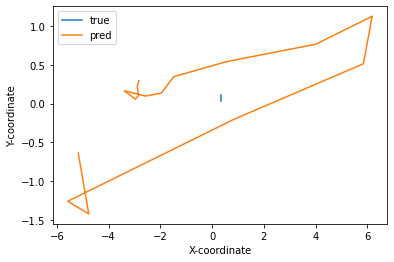

In [23]:
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)

y_predicted = esn(train_u)

x_true = []
x_pred = []
y_true = []
y_pred = []

for frame in range(len(y_predicted[0])):
    x_true.append(train_y[0][frame].numpy()[0])
    y_true.append(train_y[0][frame].numpy()[1])
    x_pred.append(y_predicted[0][frame].numpy()[0])
    y_pred.append(y_predicted[0][frame].numpy()[1])
    
plt.plot(x_true, y_true, label='true')
plt.plot(x_pred, y_pred, label='pred')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

Terrible and disguisting, but it is what it is :((

How about test datapoint?

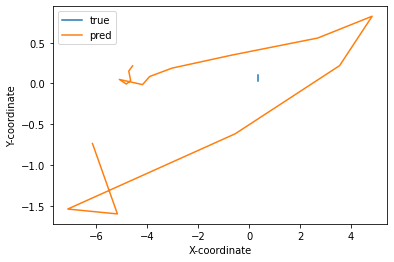

In [24]:
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)

# Make a prediction with our trained ESN
y_predicted = esn(test_u)

x_true = []
x_pred = []
y_true = []
y_pred = []

for frame in range(len(y_predicted[0])):
    x_true.append(test_y[0][frame].numpy()[0])
    y_true.append(test_y[0][frame].numpy()[1])
    x_pred.append(y_predicted[0][frame].numpy()[0])
    y_pred.append(y_predicted[0][frame].numpy()[1])
    
plt.plot(x_true, y_true, label='true')
plt.plot(x_pred, y_pred, label='pred')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

If, by any chance, you thought it can't get worse, then here it is, the "worse".

Let's now calculate the RMSE for training and testing datasets.

In [25]:
dataiter = iter(trainloader)

mse = 0

for train_u, train_y in dataiter:
    train_u, train_y = Variable(train_u), Variable(train_y)
    
    y_predicted = esn(train_u)
    
    mse += echotorch.utils.mse(y_predicted.data, train_y.data)
    
mse /= len(trainloader)
    
print('RMSE on train set:', math.sqrt(mse))

RMSE on train set: 16.07510224769264


In [26]:
dataiter = iter(testloader)

mse = 0

for test_u, test_y in dataiter:
    test_u, test_y = Variable(test_u), Variable(test_y)
    
    y_predicted = esn(test_u)
    
    mse += echotorch.utils.mse(y_predicted.data, test_y.data)
    
mse /= len(testloader)
    
print('RMSE on test set:', math.sqrt(mse))

RMSE on test set: 16.02451024208921


Surprisingly, RMSE on the testing set is smaller.

# Predicting the trajectory having three frames as a single input

Now we just repeat the same set of steps but for the dataset that has flattened data from three frames as a single input row instead of one.

In [27]:
# Loading data
train_dataset, test_dataset = TrajectoryDataset.train_test_split('data', 0.2)

train_test_split response: test fraction rounded to 0.19985639061752034 (835 simulations)


In [28]:
# Checking if what loaded is indeed what we need
print('input: ', train_dataset.__getitem__(0)[0])
print('output: ', train_dataset.__getitem__(0)[1])

input:  tensor([[0.3500, 0.2292, 0.0586, 0.7500, 0.2605, 0.1211, 0.4141, 0.7148, 0.0156,
         0.3500, 0.1086, 0.0586, 0.7500, 0.1399, 0.1211, 0.4141, 0.5942, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.2439, 0.0156],
        [0.3500, 0.1086, 0.0586, 0.7500, 0.1399, 0.1211, 0.4141, 0.5942, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.2439, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0362, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.2439, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0362, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0362, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.4141, 0.0079, 0.0156],
        [0.3500,

In [29]:
# Setting up input and output dimensions for the network
input_dim = len(train_dataset.__getitem__(0)[0][0])
output_dim = len(train_dataset.__getitem__(0)[1][0])

print(input_dim, output_dim)

27 2


In [30]:
# Data loader
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

trainloader

In [31]:
# Internal matrix
w_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    apply_spectral_radius=False
)

In [32]:
esn = etrs.LiESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=output_dim,
    leaky_rate=leaky_rate,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
)

In [33]:
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)

    # ESN need inputs and targets
    esn(inputs, targets)

In [34]:
# Now we finalize the training by computing the output matrix Wout.
esn.finalize()

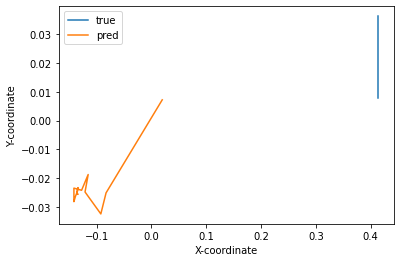

In [35]:
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)

y_predicted = esn(train_u)

x_true = []
x_pred = []
y_true = []
y_pred = []

for frame in range(len(y_predicted[0])):
    x_true.append(train_y[0][frame].numpy()[0])
    y_true.append(train_y[0][frame].numpy()[1])
    x_pred.append(y_predicted[0][frame].numpy()[0])
    y_pred.append(y_predicted[0][frame].numpy()[1])
    
plt.plot(x_true, y_true, label='true')
plt.plot(x_pred, y_pred, label='pred')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

We can't see the true trajectory, because it is bound between 0 and 1, remember? Sometimes the predicted numbers here are quite not between 0 and 1 :(

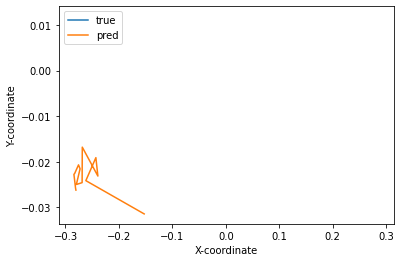

In [36]:
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)

# Make a prediction with our trained ESN
y_predicted = esn(test_u)

x_true = []
x_pred = []
y_true = []
y_pred = []

for frame in range(len(y_predicted[0])):
    x_true.append(test_y[0][frame].numpy()[0])
    y_true.append(test_y[0][frame].numpy()[1])
    x_pred.append(y_predicted[0][frame].numpy()[0])
    y_pred.append(y_predicted[0][frame].numpy()[1])
    
plt.plot(x_true, y_true, label='true')
plt.plot(x_pred, y_pred, label='pred')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

In [37]:
dataiter = iter(trainloader)

mse = 0

for train_u, train_y in dataiter:
    train_u, train_y = Variable(train_u), Variable(train_y)
    
    y_predicted = esn(train_u)
    
    mse += echotorch.utils.mse(y_predicted.data, train_y.data)
    
mse /= len(trainloader)
    
print('RMSE on train set:', math.sqrt(mse))

RMSE on train set: 0.3518182419747111


In [38]:
dataiter = iter(testloader)

mse = 0

for test_u, test_y in dataiter:
    test_u, test_y = Variable(test_u), Variable(test_y)
    
    y_predicted = esn(test_u)
    
    mse += echotorch.utils.mse(y_predicted.data, test_y.data)
    
mse /= len(testloader)
    
print('RMSE on test set:', math.sqrt(mse))

RMSE on test set: 0.3507439254057791


Doing disguistingly terrible here, yeah?

## Predicting a single pair of next coordinates from three preceeding frames

I have to say that I did not expect this method to be working. When I was trying it out before writing this final project report, the weight matrix after training was non-singular and could not be inverted, which means that the training could not be finalized.

I set the spectral radius to 1 and leaky rate to .9999999, so that after 50,000 iterations the signal rate is still slightly under 1. The only thing that I changed since my previous attempts is reducing the reservoir size from 1000 to 500. Even now sometimes I get the non-singular matrix error, but at least most of the times the training finishes successfully. You can see that the code cell numbers below don't follow the sequence above - I had to rerun these a few times to get a working output.

In [57]:
# Loading data
train_dataset, test_dataset = FrameDataset.train_test_split('data', 0.2)

train_test_split response: test fraction rounded to 0.19985639061752034 (835 simulations)


In [58]:
# Checking if what loaded is indeed what we need
print('input: ', train_dataset.__getitem__(0)[0])
print('output: ', train_dataset.__getitem__(0)[1])

input:  tensor([[0.3500, 0.2292, 0.0586, 0.7500, 0.2605, 0.1211, 0.2773, 0.7851, 0.0391,
         0.3500, 0.1086, 0.0586, 0.7500, 0.1399, 0.1211, 0.2773, 0.6645, 0.0391,
         0.3500, 0.0294, 0.0586, 0.7500, 0.0607, 0.1211, 0.2773, 0.3142, 0.0391]])
output:  tensor([[0.2773, 0.0498]])


In [59]:
# Setting up input and output dimensions for the network
input_dim = len(train_dataset.__getitem__(0)[0][0])
output_dim = len(train_dataset.__getitem__(0)[1][0])

print(input_dim, output_dim)

27 2


In [60]:
# Data loader
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

trainloader

In [61]:
# Reservoir hyper-parameters
spectral_radius = 1
leaky_rate = 0.9999999
reservoir_size = 500
connectivity = 0.1954

In [62]:
# Internal matrix
w_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = mg.NormalMatrixGenerator(
    connectivity=connectivity,
    apply_spectral_radius=False
)

In [63]:
esn = etrs.LiESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=output_dim,
    leaky_rate=leaky_rate,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
)

In [64]:
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)

    # ESN need inputs and targets
    esn(inputs, targets)

In [65]:
# Now we finalize the training by computing the output matrix Wout.
esn.finalize()

In [67]:
dataiter = iter(trainloader)

mse = 0

for train_u, train_y in dataiter:
    train_u, train_y = Variable(train_u), Variable(train_y)
    
    y_predicted = esn(train_u)
    
    mse += echotorch.utils.mse(y_predicted.data, train_y.data)
    
mse /= len(trainloader)
    
print('RMSE on train set:', math.sqrt(mse))

RMSE on train set: 0.30667686450375065


In [68]:
dataiter = iter(testloader)

mse = 0

for test_u, test_y in dataiter:
    test_u, test_y = Variable(test_u), Variable(test_y)
    
    y_predicted = esn(test_u)
    
    mse += echotorch.utils.mse(y_predicted.data, test_y.data)
    
mse /= len(testloader)
    
print('RMSE on test set:', math.sqrt(mse))

RMSE on test set: 0.308805027574426


Let's visualize the training and testing trajectories.

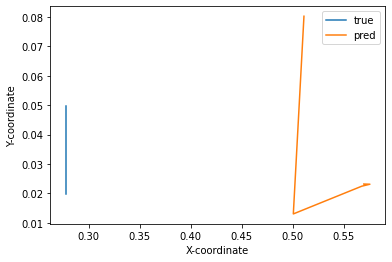

In [69]:
dataiter = iter(trainloader)

x_true = []
x_pred = []
y_true = []
y_pred = []

# One scene consists of 14 windows of 3 frames each, so I can take the first 14 to visualize
# the first trajectory.
for i in range(14):
    train_u, train_y = dataiter.next()
    train_u, train_y = Variable(train_u), Variable(train_y)

    y_predicted = esn(train_u)

    x_true.append(train_y[0][0].numpy()[0])
    y_true.append(train_y[0][0].numpy()[1])
    x_pred.append(y_predicted[0][0].numpy()[0])
    y_pred.append(y_predicted[0][0].numpy()[1])
    
plt.plot(x_true, y_true, label='true')
plt.plot(x_pred, y_pred, label='pred')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

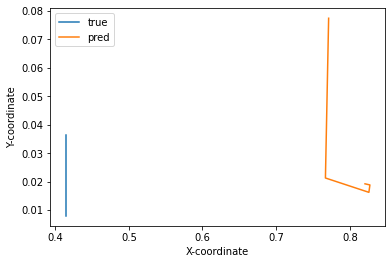

In [77]:
dataiter = iter(testloader)

x_true = []
x_pred = []
y_true = []
y_pred = []

# One scene consists of 14 windows of 3 frames each, so I can take the first 14 to visualize
# the first trajectory.
for i in range(14):
    test_u, test_y = dataiter.next()
    test_u, test_y = Variable(test_u), Variable(test_y)

    y_predicted = esn(test_u)

    x_true.append(test_y[0][0].numpy()[0])
    y_true.append(test_y[0][0].numpy()[1])
    x_pred.append(y_predicted[0][0].numpy()[0])
    y_pred.append(y_predicted[0][0].numpy()[1])
    
plt.plot(x_true, y_true, label='true')
plt.plot(x_pred, y_pred, label='pred')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

# Conclusion

In this assignment I trained three ESN models to predict the trajectory of the ball falling, including interactions with two other balls on the scene. Here are the results that I obtained:

- RMSE for the first model (predicting the scene evolution):

    - Training set: 16.07510224769264
    
    - Testing set: 16.02451024208921
    
    - The predicted trajectories are not bound in the range of normalized coordinates and visually don't match the ground truth at all.
    
- RMSE for the second model (predicting a ball trajectory on the entire scene having scene states at three frames as an input instance):

    - Training set: 0.3518182419747111
    
    - Testing set: 0.3507439254057791
    
    - The predicted trajctories are much closer to the ground truth but are still ugly. The values are much closer to the normalized coordinates bounds.
    
- RMSE for the third model (predicting the coordinates of one ball on the next frame given the scene states at three preceeding frames as an input):

    - Training set: 0.30667686450375065
    
    - Testing set: 0.308805027574426
    
    - Predicted trajectories, while are not matching, at least have a somewhat similar shapes, which is a great success already.
    
    - This model, however, doesn't necessarily converge, which means it still requires some improvement.
    
Judging only from the results here, I think the third model would be the best choice. It has the smallest error rates, and the predicted trajectory visually has a shape close to what should be in the reality.

Next steps, that will be a part of the capstone journey, would be exploring the performance of such networks on the deterministic free fall trajectories.